<a href="https://colab.research.google.com/github/frumgar/CNL/blob/master/PINN_van_dep_Pol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics-informed neural network (PINN): van der Pol

In this demo we will code a PINN from scratch in `PyTorch` and use it to solve simulation and inversion problems related to the van der Pol oscillator.

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## Problem overview

We are going to use a PINN to solve problems related to the **damped harmonic oscillator**:

<img src="oscillator.gif" width="500">




Descripción canónica:

$$
\mu(1-x^2)\dot x-10x=0~, \quad N N(t,u)=0
$$

Tomemos $\mu=10$ (al menos por ahora).

Consideremos una solución inicial cercana al origen $x_{0,ch}$
$$
x(t=0) = .1~~,~~\dfrac{d x}{d t}(t=0) = 0~.
$$

y una más lejana $x_{0,gr}$

$$
x(t=0) = 4~~,~~\dfrac{d x}{d t}(t=0) = 0~.
$$


For a more detailed mathematical description of the harmonic oscillator, check out this blog post: https://beltoforion.de/en/harmonic_oscillator/.

## Workflow overview

There are **two scientific tasks** related to the harmonic oscillator we will use a PINN for:

>First, we will **simulate** the system using a PINN, given its initial conditions.

>Second, we will **invert** for underlying parameters of the system using a PINN, given some noisy observations of the oscillator's displacement.

## Initial setup

First, we define a few helper functions.

In [3]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0 # chequea que d sea menor que w0
    w = np.sqrt(w0**2-d**2) # calcula w a partir de los datos (asume m=1)
    phi = np.arctan(-d/w) # calcula la fase de la oscilación amortiguada
    A = 1/(2*np.cos(phi)) # calcula la amplitud de la oscilación amortiguada
    cos = torch.cos(phi+w*t) # calcula la sinusoide e la oscilación amortiguada
    exp = torch.exp(-d*t) # calcula la amortiguación
    u = exp*2*A*cos # calcula la expresión concreta de la solución analítica
    return u

def sol_exacta_osc_armonico(t,x0):
    "Defines the analytical solution to the un-damped harmonic oscillator problem above."
    u =   x0*torch.cos(t)
    return u



class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## Task 1: train a PINN to simulate the system

#### Task

The first task is to use a PINN to **simulate** the system.

Specifically, our inputs and outputs are:

- Inputs: underlying differential equation and the initial conditions of the system
- Outputs: estimate of the solution, $u(t)$

#### Approach

The PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
N\!N(t;\theta) \approx x(t)~,
$$

For this task, we use $\mu=10$, $t\in [0,10]$.

#### Loss function

To simulate the system, the PINN is trained with the following loss function associated to one of the initial conditions:

$$
\mathcal{L}(\theta)= (N\!N(0;\theta) - .1)^2 + \lambda_1 \left(\frac{d N\!N}{dt}(0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( vdP(t,u)  \right)^2
$$

#### Computing gradients

To compute gradients of the neural network with respect to its inputs, we will use `torch.autograd.grad`:

<img src="autograd_grad.png" width="800" align="left">

In [4]:
T = 40; # tiempo total de simulacion
t_test = torch.linspace(0,T,10).view(-1,1) # tiempos de testeo
u_exactvdp=torch.zeros(10,1)
u_exactvdp[0] = 5.0
u_exactvdp[1] = 3.9699
u_exactvdp[2] = 2.4586
u_exactvdp[3] = -1.8286
u_exactvdp[4] = 0.8765
u_exactvdp[5] = 1.4700
u_exactvdp[6] = -1.8360
u_exactvdp[7] = 0.9106
u_exactvdp[8] = 1.3941
u_exactvdp[9] = -1.8493

#t_test, u_exact

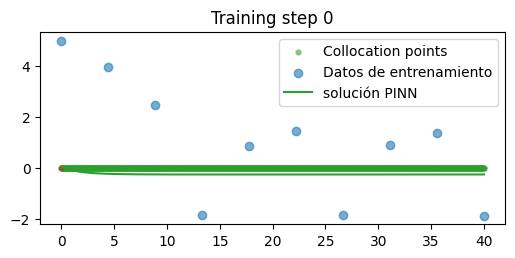

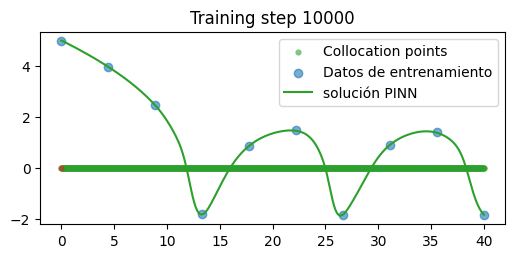

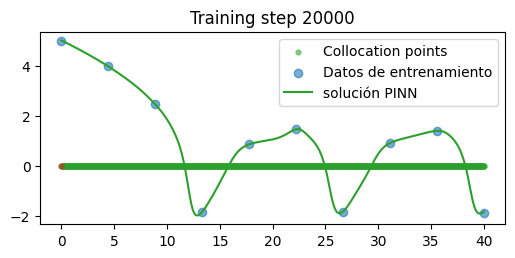

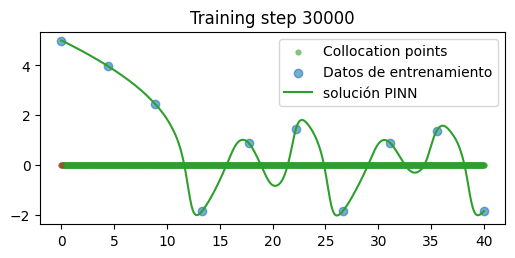

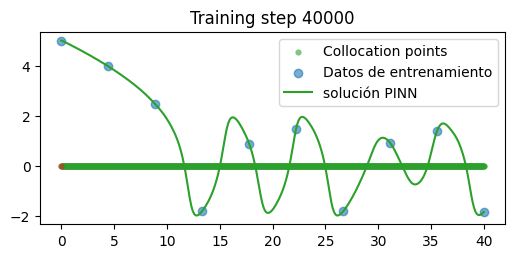

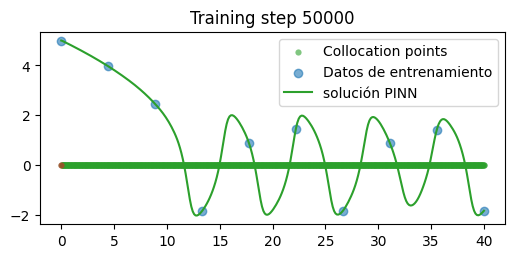

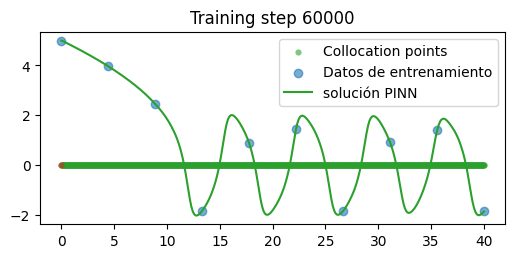

In [5]:
torch.manual_seed(123)

# define a neural network to train
pinn = FCN(1,1,32,3)

T = 40; # tiempo total de simulacion

# define boundary points, for the boundary loss
# TODO # (1, 1)
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True) # (1, 1)

# define training points over the entire domain, for the physics loss
# TODO # (Tcol, 1)
Tcol = 1000;
t_physics = torch.linspace(0,T,Tcol).view(-1,1).requires_grad_(True)# (30, 1)
# son los tiempos en lo que se va a tratar de imponer el cumplimiento de la ec dif.

# train the PINN
d, w0 = 2, 20
mu, k = 2*d, w0**2 # asume m=1
mu=1;
x0=5; # posición inicial, con velocidad inicial nula


t_total = torch.linspace(0,T,300).view(-1,1).requires_grad_(True) # tiempo total de simulación
#t_test = torch.linspace(0,T,10).view(-1,1) # tiempos de testeo

u_exact = exact_solution(d, w0, t_test) # solución exacta en los tiempos de testeo, para entrenar "sin ruido"
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-3)



for i in range(60001):
    optimiser.zero_grad()

    # compute each term of the PINN loss function above
    # using the following hyperparameters
    lambda1, lambda2 = 1e-1, 1e-2


    # compute boundary loss
    # TODO
    u = pinn(t_boundary)# (1, 1)
    loss1 = (torch.squeeze(u) - x0)**2 # x(0) =  x0

    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]# (1, 1)
    # calculo de la derivada temporal de la u en t=0 como salida de la red.

    loss2 = (torch.squeeze(dudt) - 0)**2 # \dot x(0)=0

    # compute physics loss
    # TODO
    u = pinn(t_physics)# (30, 1) # evalúo la red en los instantes que quiero imponer la ec dif
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]# (30, 1) cálculo de la derivada primera
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]# (30, 1) cálculo de la derivada segunda
    #loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2) # función de costo que penaliza apartarse de la ec dif
    u_test = pinn(t_test)
    u_exact = sol_exacta_osc_armonico(t_test,x0)
    loss1 = loss1 + + torch.mean((u_test-u_exactvdp)**2) # ajuste a datos
  #  loss3 = torch.mean((d2udt2 + u)**2)  # el oscilador armónico
    loss3 = torch.mean((d2udt2 - mu*(1-u*u)*dudt + u)**2) # van der pol (mu=0 da el oscilador armónico)

    # backpropagate joint loss, take optimiser step
    loss = loss1 + lambda1*loss2 + lambda2*loss3 # costo total a minimizar
    loss.backward() #
    optimiser.step() #

    # plot the result as training progresses
    if i % 10000 == 0:
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = pinn(t_total).detach()
        uu = pinn(t_physics)# (30, 1) # evalúo la red en los instantes que quiero imponer la ec dif
        dudt = torch.autograd.grad(uu, t_physics, torch.ones_like(uu), create_graph=True)[0]# (30, 1) cálculo de la derivada primera
  #        uu = pinn(t_total)
 #       dudt = torch.autograd.grad(uu, t_total, torch.ones_like(u))[0] #
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, label="Collocation points", color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                  torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.scatter(t_test[:,0], u_exactvdp[:,0], label="Datos de entrenamiento", color="tab:blue", alpha=0.6)
        plt.plot(t_total.detach()[:,0], u[:,0], label="solución PINN", color="tab:green")
 #       plt.plot(uu[:,0], dudt[:,0], label="solución PINN", color="tab:red")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

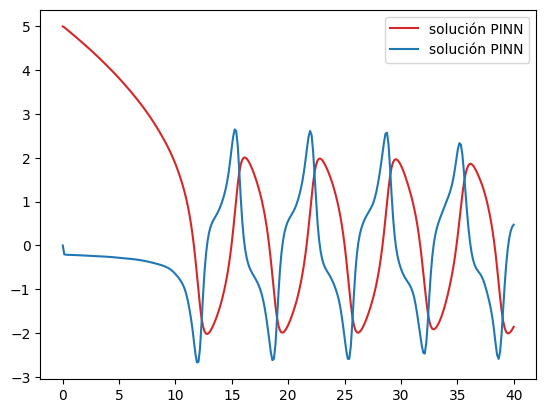

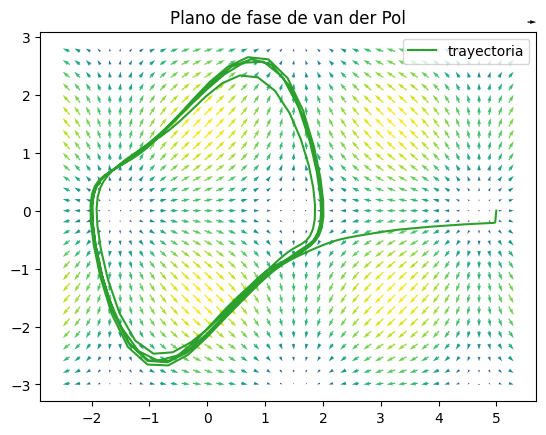

In [9]:
# con la red ya entrenada, graficamos las curvas temporales y el plano de fase

ufinal = pinn(t_total)
uu = pinn(t_physics)# (30, 1) # evalúo la red en los instantes que quiero imponer la ec dif
dudtfinal = torch.autograd.grad(ufinal,t_total,torch.ones_like(ufinal), create_graph=True)[0]

#torch.save(ufinal, 'ufinal.pt')
#torch.save(dudtfinal, 'dudtfinal.pt')
#torch.save(t_total, 't_total.pt')

tiempo = t_total.detach() # tiempo para graficar
uplot = ufinal.detach()   # posicion para graficar
dudtplot = dudtfinal.detach()  # velocidad para graficar


plt.figure
plt.plot(tiempo,uplot, label="solución PINN", color="tab:red") # posición temporal
plt.plot(tiempo,dudtplot, label="solución PINN", color="tab:blue") # velocidad temporal
plt.legend()
plt.show()

plt.figure
plt.plot(uplot,dudtplot, label="trayectoria", color="tab:green")
X, Y = np.meshgrid(np.arange(-2.5, 5.5, .2), np.arange(-3, 3, .2))
M = np.hypot(np.cos(X), np.sin(Y))  # determines the colors based on the hypotenuse
#plt.figure(figsize=(5, 5), dpi=100).patch.set_color('white')
Q = plt.quiver(X, Y, np.cos(X), np.sin(Y), M, units='x', pivot='tip', width=0.022,
               scale=1 / 0.15)
qk = plt.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',
                   coordinates='figure')
plt.title("Plano de fase de van der Pol")
plt.legend()
plt.show()



## Task 2: train a PINN to invert for underlying parameters

#### Task

The second task is to use a PINN to **invert** for underlying parameters.

Specifically, our inputs and outputs are:

- Inputs: noisy observations of the oscillator's displacement, $u_{\mathrm{obs}}$
- Outputs: estimate $\mu$, the coefficient of friction

#### Approach

Similar to above, the PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
N\!N(t;\theta) \approx u(t)~,
$$

However here we assume $\mu$ is **not known** and we treat it as an additional **learnable parameter** when training the PINN.

#### Loss function

The PINN is trained with the loss function:

$$
\mathcal{L}(\theta, \mu)= \frac{1}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] N\!N(t_{i};\theta)  \right)^2 + \frac{\lambda}{M} \sum^{M}_{j} \left( N\!N(t_{j};\theta) - u_{\mathrm{obs}}(t_{j}) \right)^2
$$

True value of mu: 4


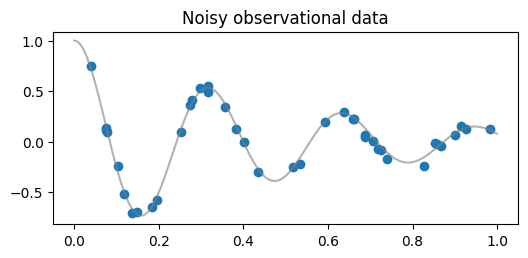

In [ ]:
# first, create some noisy observational data
torch.manual_seed(123)
d, w0 = 2, 20
print(f"True value of mu: {2*d}")
t_obs = torch.rand(40).view(-1,1)
u_obs = exact_solution(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

plt.figure(figsize=(6,2.5))
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0])
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.show()

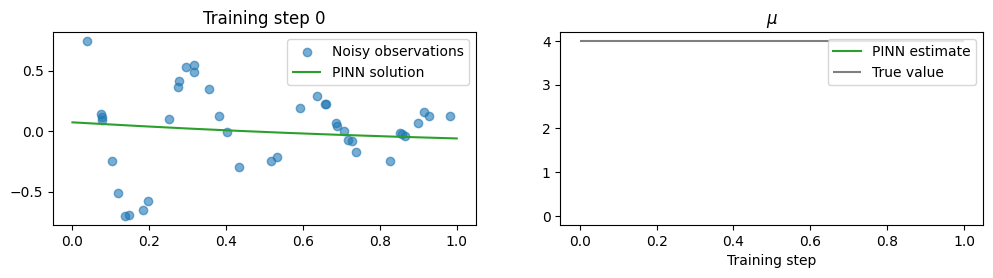

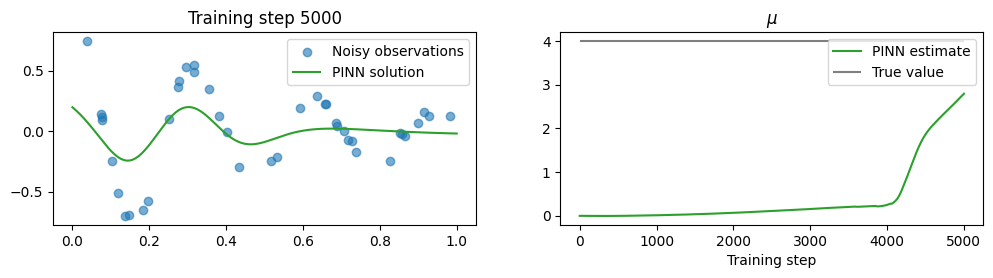

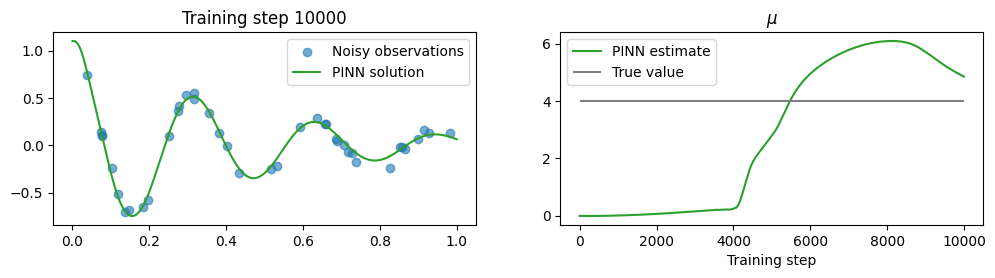

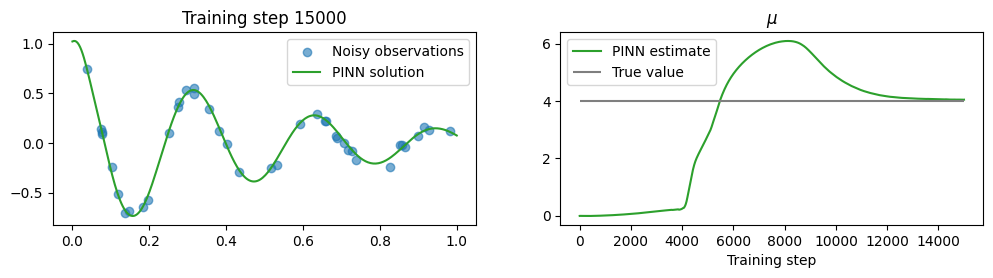

In [ ]:
torch.manual_seed(123)

# define a neural network to train
pinn = FCN(1,1,32,3)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# (30, 1)

# train the PINN
d, w0 = 2, 20
_, k = 2*d, w0**2
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

# treat mu as a learnable parameter, add it to optimiser
# TODO
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
optimiser = torch.optim.Adam(list(pinn.parameters())+[mu],lr=1e-3)
mus = []
for i in range(15001):
    optimiser.zero_grad()

    # compute each term of the PINN loss function above
    # using the following hyperparameters
    lambda1 = 1e4

    # compute physics loss
    u = pinn(t_physics)# (30, 1)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]# (30, 1)
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]# (30, 1)
    loss1 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # compute data loss
    # TODO
    u = pinn(t_obs)
    loss2 = torch.mean((u - u_obs)**2)

    # backpropagate joint loss, take optimiser step
    loss = loss1 + lambda1*loss2
    loss.backward()
    optimiser.step()

    # record mu value
    mus.append(mu.item())

    # plot the result as training progresses
    if i % 5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(12,2.5))

        plt.subplot(1,2,1)
        plt.scatter(t_obs[:,0], u_obs[:,0], label="Noisy observations", alpha=0.6, color="tab:blue")
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()

        plt.subplot(1,2,2)
        plt.title("$\mu$")
        plt.plot(mus, label="PINN estimate", color="tab:green")
        plt.hlines(2*d, 0, len(mus), label="True value", color="tab:grey")
        plt.xlabel("Training step")
        plt.legend()

        plt.show()